In [24]:
"""# Importing Libraries"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from scipy.ndimage import zoom
from skimage.measure import block_reduce
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.optimizers import Adam
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.layers.core import Reshape
from keras.layers import LSTM

In [3]:
"""# Loading Data"""

path = "../../Cog_DataSets/testing/"
# path = "drive/MyDrive/Colab Notebooks/CogAge/Datasets/testing/"
test_acc = np.load(path+"testAccelerometer.npy")
test_grav = np.load(path+"testGravity.npy")
test_gyro = np.load(path+"testGyroscope.npy")
test_jinsAcc = np.load(path+"testJinsAccelerometer.npy")
test_jinsGyro = np.load(path+"testJinsGyroscope.npy")
test_Label =np.load(path+"testLabels.npy") 
test_linAcc = np.load(path+"testLinearAcceleration.npy")
test_MsAcc = np.load(path+"testMSAccelerometer.npy")
test_MsGyro = np.load(path + "testMSGyroscope.npy")
test_MsMag = np.load(path+"testMagnetometer.npy")
# test_acc

path = "../../Cog_DataSets/training/"
# path = "drive/MyDrive/Colab Notebooks/CogAge/Datasets/training/"
train_acc = np.load(path+"trainAccelerometer.npy")
train_grav = np.load(path+"trainGravity.npy")
train_gyro = np.load(path+"trainGyroscope.npy")
train_jinsAcc = np.load(path+"trainJinsAccelerometer.npy")
train_jinsGyro = np.load(path+"trainJinsGyroscope.npy")
train_Label =np.load(path+"trainLabels.npy") 
train_linAcc = np.load(path+"trainLinearAcceleration.npy")
train_MsAcc = np.load(path+"trainMSAccelerometer.npy")
train_MsGyro = np.load(path + "trainMSGyroscope.npy")
train_MsMag = np.load(path+"trainMagnetometer.npy")
# print(train_Label.shape)

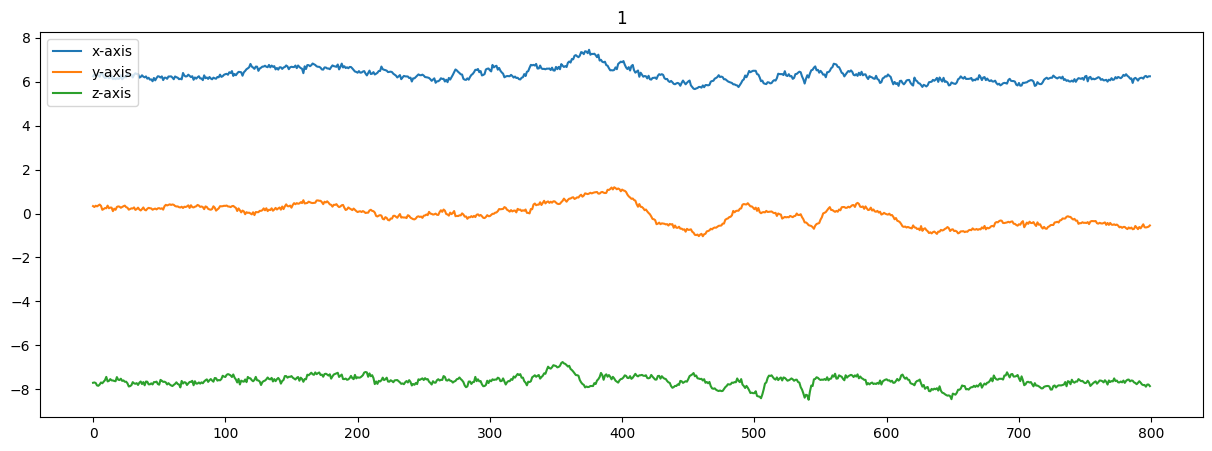

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.plot(train_acc[100][:])
plt.legend(['x-axis', 'y-axis', 'z-axis'], loc="upper left")
plt.title(train_Label[100])
# axs[1].plot(train_MsAcc[0][:])
# plt.legend(['x-axis', 'y-axis', 'z-axis'], loc="upper left")
# axs[2].plot(train_jinsAcc[0][:])
# plt.legend(['x-axis', 'y-axis', 'z-axis'], loc="upper left")
plt.show()

In [10]:
"""# Reshape and stack Data Before Fitting to Model"""
# changing shape of sensor data to (#,400,3)
# downsample
train_acc_reshaped = block_reduce(train_acc, block_size=(1, 2, 1), func=np.mean)
train_gyro_reshaped = block_reduce(train_gyro, block_size=(1, 2, 1), func=np.mean)
train_grav_reshaped = block_reduce(train_grav, block_size=(1, 2, 1), func=np.mean)
train_linAcc_reshaped = block_reduce(train_linAcc, block_size=(1, 2, 1), func=np.mean)
# upsample
train_MsAcc_reshaped = resize(train_MsAcc, (2284, 400, 3), mode='edge')
train_MsGyro_reshaped = resize(train_MsGyro, (2284, 400, 3), mode='edge')
# upsample
train_MsMag_reshaped = np.repeat(train_MsMag, 2, axis=1)
train_jinsAcc_reshaped = np.repeat(train_jinsAcc, 5, axis=1)
train_jinsGyro_reshaped = np.repeat(train_jinsGyro, 5, axis=1)

test_acc_reshaped = block_reduce(test_acc, block_size=(1, 2, 1), func=np.mean)
test_gyro_reshaped = block_reduce(test_gyro, block_size=(1, 2, 1), func=np.mean)
test_grav_reshaped = block_reduce(test_grav, block_size=(1, 2, 1), func=np.mean)
test_linAcc_reshaped = block_reduce(test_linAcc, block_size=(1, 2, 1), func=np.mean)
test_MsAcc_reshaped = resize(test_MsAcc, (2288, 400, 3), mode='edge')
test_MsGyro_reshaped = resize(test_MsGyro, (2288, 400, 3), mode='edge')
test_MsMag_reshaped = np.repeat(test_MsMag, 2, axis=1)
test_jinsAcc_reshaped = np.repeat(test_jinsAcc, 5, axis=1)
test_jinsGyro_reshaped = np.repeat(test_jinsGyro, 5, axis=1)

In [11]:
# all data of shape #,400,3
# adding all relative data.
# Mobile training accelerometer + Mobile testing accelerometer data
train_acc_reshaped = np.append(train_acc_reshaped,test_acc_reshaped, axis=0)
train_gyro_reshaped = np.append(train_gyro_reshaped,test_gyro_reshaped, axis=0)
train_grav_reshaped = np.append(train_grav_reshaped,test_grav_reshaped, axis=0)
train_linAcc_reshaped = np.append(train_linAcc_reshaped,test_linAcc_reshaped, axis=0)
train_MsAcc_reshaped = np.append(train_MsAcc_reshaped,test_MsAcc_reshaped, axis=0)
train_MsGyro_reshaped = np.append(train_MsGyro_reshaped,test_MsGyro_reshaped, axis=0)
train_MsMag_reshaped = np.append(train_MsMag_reshaped,test_MsMag_reshaped, axis=0)
train_jinsAcc_reshaped = np.append(train_jinsAcc_reshaped,test_jinsAcc_reshaped, axis=0)
train_jinsGyro_reshaped = np.append(train_jinsGyro_reshaped,test_jinsGyro_reshaped, axis=0)


# print("Shape of all sensors after up/down sample... ", train_acc_reshaped.shape, train_gyro_reshaped.shape, train_grav_reshaped.shape, train_linAcc_reshaped.shape
#                        , train_MsAcc_reshaped.shape, train_MsGyro_reshaped.shape, train_MsMag_reshaped.shape,
#                        train_jinsAcc_reshaped.shape, train_jinsGyro_reshaped.shape)

# all data of shape 4572,400,3
# 4572 = 2284(training) + 2288(testing)


# stack
all_data = np.stack([train_acc_reshaped, train_gyro_reshaped, train_grav_reshaped, train_linAcc_reshaped
                       , train_MsAcc_reshaped, train_MsGyro_reshaped, train_MsMag_reshaped,
                       train_jinsAcc_reshaped, train_jinsGyro_reshaped], axis=-1)

all_Label = np.append(train_Label, test_Label, axis=-1)
print(all_data.shape)

(4572, 400, 3, 9)


In [12]:
# 90% training data + labels
train_data = all_data[: int(all_data.shape[0]*0.7)]
# 10% testing data + labels
test_data = all_data[int(all_data.shape[0]*0.7):]
train_labels = all_Label[: int(all_Label.shape[0]*0.7)]
test_labels = all_Label[int(all_Label.shape[0]*0.7):]

print("\nShape of training and testin data + labels...\n")
print(train_data.shape, test_data.shape)
print(train_labels.shape, test_labels.shape)


# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

print("Shape of training + validation Data")
print(np.shape(x_train), np.shape(y_train))

y_train = to_categorical(y_train, num_classes=55)
y_val = to_categorical(y_val, num_classes=55)

print("Shape of training + validation Labels")
print(np.shape(y_train), np.shape(y_val))



Shape of training and testin data + labels...

(3200, 400, 3, 9) (1372, 400, 3, 9)
(3200,) (1372,)
Shape of training + validation Data
(2560, 400, 3, 9) (2560,)
Shape of training + validation Labels
(2560, 55) (640, 55)


In [25]:
# HYPER PARAMTERS

# Activation function of the convolutional layer(s)
activationConv = 'relu'

# Output dimension of the LSTM
outputLSTM = 100

# Parameters of the dense layer
activationMLP = 'relu'
inputMLP = 1500

# Training parameters
batchSize = 320
numberOfEpochs = 10
learningRate = 0.001

input_shape = (400,3,9)
nbClasses = 55
timeWindow = 400
nbSensors = 9

In [26]:
#-------------------------------------------------------------------------------------------------------
# normLstm: define a batch normalization + LSTM DNN
#-------------------------------------------------------------------------------------------------------
def normLstm(
    inputShape,
    timeWindow,
    nbSensors,
    outputLSTM,
    inputMLP,
    activationMLP,
    nbClasses,
    withSoftmax=True):

    model = Sequential()
    nbFeaturePerSensor = 3

    # Batch normalization layer
    model.add(BatchNormalization(input_shape=inputShape))

    # LSTM layer with a many-to-one implementation
    # Note: size of the output = (outputSizeLastConv, outputLSTM)
    model.add(Reshape((timeWindow, nbSensors * nbFeaturePerSensor)))
    model.add(LSTM(outputLSTM))
  
    # Fully-connected layer
    model.add(Dense(inputMLP, activation=activationMLP))

    model.add(Dropout(0.5))

    # Softmax layer
    if withSoftmax:
        model.add(Dense(nbClasses, activation='softmax'))

    # Return the model
    return model

In [27]:
model = normLstm(inputShape=input_shape,
                     timeWindow=timeWindow,
                     nbSensors=nbSensors,
                     outputLSTM=outputLSTM,
                     inputMLP=inputMLP,
                     activationMLP=activationMLP,
                     nbClasses=nbClasses)



model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=learningRate),
    metrics=['accuracy']
)

2023-05-09 20:23:49.730859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 20:23:49.733044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 20:23:49.734838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 400, 3, 9)        36        
 hNormalization)                                                 
                                                                 
 reshape_1 (Reshape)         (None, 400, 27)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               51200     
                                                                 
 dense_2 (Dense)             (None, 1500)              151500    
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_3 (Dense)             (None, 55)                82555     
                                                      

In [31]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=numberOfEpochs,
    batch_size=batchSize
)

Epoch 1/10


2023-05-09 20:26:14.139862: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 110592000 exceeds 10% of free system memory.


8/8 [==============================] - 9s 1s/step - loss: 1.8000 - accuracy: 0.4797 - val_loss: 2.4156 - val_accuracy: 0.2875
Epoch 2/10
8/8 [==============================] - 9s 1s/step - loss: 1.6876 - accuracy: 0.5188 - val_loss: 2.4161 - val_accuracy: 0.3359
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 1.6417 - accuracy: 0.5293 - val_loss: 2.3166 - val_accuracy: 0.3469
Epoch 4/10
8/8 [==============================] - 11s 1s/step - loss: 1.5727 - accuracy: 0.5488 - val_loss: 2.4109 - val_accuracy: 0.3297
Epoch 5/10
8/8 [==============================] - 9s 1s/step - loss: 1.5981 - accuracy: 0.5473 - val_loss: 2.2456 - val_accuracy: 0.3812
Epoch 6/10
8/8 [==============================] - 11s 1s/step - loss: 1.6348 - accuracy: 0.5375 - val_loss: 2.3601 - val_accuracy: 0.3609
Epoch 7/10
8/8 [==============================] - 14s 2s/step - loss: 1.6516 - accuracy: 0.5219 - val_loss: 2.2761 - val_accuracy: 0.3594
Epoch 8/10
8/8 [==============================] 

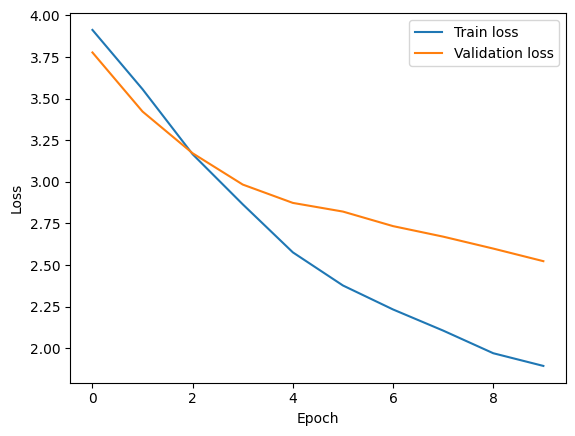

In [30]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# plot the graph
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
estimatedLabels = np.argmax(model.predict(test_data),axis=-1)
estimatedLabels = estimatedLabels.flatten()

accuracy = accuracy_score(test_labels,estimatedLabels)
weightedF1 = f1_score(test_labels,estimatedLabels,average='weighted')
averageF1 = f1_score(test_labels,estimatedLabels,average='macro')
#confMat = confusion_matrix(testingLabels,estimatedLabels,labels=labelsTable.values())
allF1Scores = f1_score(test_labels,estimatedLabels,average=None)

# Print results
print('   Test accuracy = %.2f %%' % (accuracy*100))
print('   Weighted F1-score = %.4f' % (weightedF1))
print('   Average F1-score = %.4f' % (averageF1))
# print('   All F1-scores:')
# print(allF1Scores)
print('-------------------------------------------------------')

2023-05-09 11:29:16.918836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 11:29:16.922453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 11:29:16.924621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 1s 66ms/step
   Test accuracy = 47.38 %
   Weighted F1-score = 0.4742
   Average F1-score = 0.4428
-------------------------------------------------------
